In [1]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [2]:
# coordinates of given house stored as dataframe for scalability
house_coords = pd.DataFrame({'id': [1],
                             'house_lat': [45.55],
                             'house_lon': [80.22]})

In [3]:
# load dataframe
path = "C:/Users/Eli/PycharmProjects/interview_skynet_software/interviewrequestskynetsoftware/"
regionID_characteristics = pd.read_csv(path+"regionID_and_Characteristics.csv")
regionID_characteristics.head()

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories
0,451897,189734,44.170834,-78.787498,L0B,2,11,21,0
1,451898,189735,44.187500,-78.787498,L0B,2,11,21,0
2,451929,189766,43.837502,-79.145836,L1X,2,11,21,0
3,451930,189767,43.837502,-79.137497,L1X,2,11,21,0
4,452090,189927,45.887501,-80.720833,P0G,2,11,21,0


My plan is to use a ball tree. A ball tree splits data into a series of spheres such that points closer to each other go in one child whereas the other set of nearby points goes in the other child. Pictorally we have

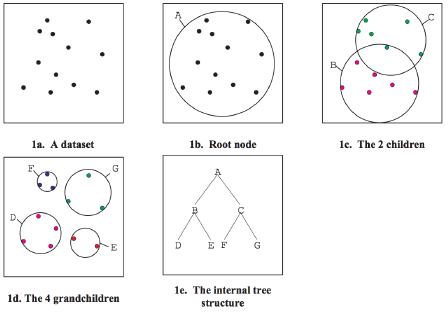

In [4]:
from IPython.display import Image
Image("ball_tree.PNG")

In [5]:
# Create a BallTree using the haversine metric, which expects
# (lat, lon) in radians and returns distances in radians
nbrs = NearestNeighbors(algorithm='ball_tree',
                        metric='haversine',
                        leaf_size=2,
                        n_jobs=-1,   # number of parallel jobs to run, -1 means all processors
                        n_neighbors=1
                        ).fit(np.radians(regionID_characteristics[['Latitude', 'Longitude']].abs()))

In [6]:
%%timeit
NearestNeighbors(algorithm='ball_tree',
                 metric='haversine',
                 leaf_size=2, 
                 n_jobs=-1,
                 n_neighbors=1).fit(np.radians(regionID_characteristics[['Latitude', 'Longitude']].abs()))

3.13 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
NearestNeighbors(algorithm='ball_tree',
                 metric='haversine',
                 leaf_size=2,
                 n_jobs=1,
                 n_neighbors=1).fit(np.radians(regionID_characteristics[['Latitude', 'Longitude']].abs()))

3.11 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# convert to rads
house_coords_rad = np.radians(house_coords[['house_lat', 'house_lon']])

# query the tree for the nearest regionID
distances, indices = nbrs.kneighbors(house_coords_rad)

# dists is in rad; convert to km, scale unit radius to radius of earth
distances.flatten()[0] * 6371

2.7004372611084073

In [9]:
# return the entry for the nearest regionID
closest_region = regionID_characteristics.iloc[indices.flatten()]
closest_region

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories
88,452174,190011,45.554169,-80.254166,P0G,3,11,23,0


In [10]:
# load event loss dataframe
regionID_event_loss = pd.read_csv(path+"regionID_and_event_losses.csv")
regionID_event_loss.head()

,Unnamed: 0,RegionID,EventID,YearID,GroundUpLoss
0,0,189734,5758.0,39222,1.185160
1,1,189735,5758.0,39222,1.187346
2,2,189734,5758.0,39223,3.580194
3,3,189735,5758.0,39223,3.582398
4,4,189766,5758.0,39223,1.214846


In [11]:
# grab the region id for the nearest region
cr_ids = closest_region['RegionID'].values

# select the group from the event loss dataset and compute the mean loss
mean_loss = regionID_event_loss.groupby(['RegionID']).get_group(cr_ids[0])['GroundUpLoss'].mean() * 100000
mean_loss

1292228.089549523

In [12]:
# we can try dask for improved performance
import dask.dataframe as dd     # pandas-like api supporting parallelization

# want a partition size small enough to easily fit into memory but large enough to make the overhead worth it

mean_loss_dask = dd.from_pandas(regionID_event_loss, npartitions=4).groupby(['RegionID'])\
                   .get_group(cr_ids[0])['GroundUpLoss'].mean().compute() * 100000
mean_loss_dask

1292228.089549523

In [13]:
%timeit dd.from_pandas(regionID_event_loss, npartitions=4).groupby(['RegionID'])\
          .get_group(cr_ids[0])['GroundUpLoss'].mean().compute() * 100000

253 ms ± 6.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit regionID_event_loss.groupby(['RegionID']).get_group(cr_ids[0])['GroundUpLoss'].mean() * 100000

70.6 ms ± 897 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The dataframe is too small to see improvements from dask at this point

In [15]:
# now we want to find the nearest 5 points to our regionID sharing the same characteristics

# query the ball tree for the nearest 
distances_2, indices_2 = nbrs.kneighbors(np.radians(closest_region[['Latitude', 'Longitude']].abs()), n_neighbors=6)

# return the entry for the nearest regionID
nearest_five = regionID_characteristics.iloc[indices_2.flatten()]
nearest_five

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories
88,452174,190011,45.554169,-80.254166,P0G,3,11,23,0
87,452173,190010,45.545834,-80.262497,P0G,3,11,23,0
80,452166,190003,45.545834,-80.279167,P0G,3,13,23,0
84,452170,190007,45.520832,-80.270836,P0G,3,11,23,0
83,452169,190006,45.512501,-80.270836,P0G,3,11,23,0
79,452165,190002,45.512501,-80.279167,P0G,3,13,23,0


We see that some of them don't have the same characteristics, we need to restrict to the subset
with the same characteristics, we could keep querring until we find all five, or we could make
a new tree on the smaller set

In [16]:
# get the group containing the same characteristics as the closest region
chrtstcs_tuple = tuple(closest_region[['Characteristic_1',
                                       'Characteristic_2',
                                       'Characteristic_3']].values.flatten())

closest_chars = regionID_characteristics.groupby(['Characteristic_1',
                                       'Characteristic_2',
                                       'Characteristic_3']).get_group(chrtstcs_tuple)
closest_chars

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories
81,452167,190004,45.895832,-80.279167,P0G,3,11,23,0
82,452168,190005,45.954166,-80.279167,P0G,3,11,23,0
83,452169,190006,45.512501,-80.270836,P0G,3,11,23,0
84,452170,190007,45.520832,-80.270836,P0G,3,11,23,0
85,452171,190008,45.954166,-80.270836,P0G,3,11,23,0
86,452172,190009,45.362499,-80.262497,P0G,3,11,23,0
87,452173,190010,45.545834,-80.262497,P0G,3,11,23,0
88,452174,190011,45.554169,-80.254166,P0G,3,11,23,0
89,452175,190012,45.379166,-80.245834,P0G,3,11,23,0
90,452176,190013,45.495834,-80.245834,P0G,3,11,23,0


In [17]:
closest_char_nbrs = NearestNeighbors(algorithm='ball_tree',
                    metric='haversine',
                    leaf_size=2,
                    n_jobs=-1,     # number of parallel jobs to run, -1 means all processors
                    n_neighbors=6, # set to 6 since our region is included
                    ).fit(np.radians(closest_chars[['Latitude', 'Longitude']].abs()))

# query the new ball tree for the nearest
distances_3, indices_3 = closest_char_nbrs.kneighbors(np.radians(closest_region[['Latitude', 'Longitude']].abs()))

nearest_five_2 = closest_chars.iloc[indices_3.flatten()]
nearest_five_2

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories
88,452174,190011,45.554169,-80.254166,P0G,3,11,23,0
87,452173,190010,45.545834,-80.262497,P0G,3,11,23,0
84,452170,190007,45.520832,-80.270836,P0G,3,11,23,0
83,452169,190006,45.512501,-80.270836,P0G,3,11,23,0
90,452176,190013,45.495834,-80.245834,P0G,3,11,23,0
93,452179,190016,45.404167,-80.237503,P0G,3,11,23,0


In [18]:
pd.options.mode.chained_assignment = None

# add distance column
d_column = distances_3.flatten() * 6371
nearest_five_2.loc[:,'Closest Region Distances'] = d_column
nearest_five_2

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories,Closest Region Distances
88,452174,190011,45.554169,-80.254166,P0G,3,11,23,0,0.000000
87,452173,190010,45.545834,-80.262497,P0G,3,11,23,0,1.131289
84,452170,190007,45.520832,-80.270836,P0G,3,11,23,0,3.927705
83,452169,190006,45.512501,-80.270836,P0G,3,11,23,0,4.811773
90,452176,190013,45.495834,-80.245834,P0G,3,11,23,0,6.518951
93,452179,190016,45.404167,-80.237503,P0G,3,11,23,0,16.729980


In [19]:
# calculate the mean loss for nearest 5 regions
mean_loss_list = []
for reg_id in nearest_five_2['RegionID'].values:
    mean_loss_list.append(regionID_event_loss.groupby(['RegionID']).get_group(reg_id)['GroundUpLoss'].mean() * 100000)

# add mean loss column
nearest_five_2['Mean Loss'] = mean_loss_list
nearest_five_2

,Unnamed: 0,RegionID,Latitude,Longitude,FSA,Characteristic_1,Characteristic_2,Characteristic_3,Stories,Closest Region Distances,Mean Loss
88,452174,190011,45.554169,-80.254166,P0G,3,11,23,0,0.000000,1.292228e+06
87,452173,190010,45.545834,-80.262497,P0G,3,11,23,0,1.131289,1.116740e+06
84,452170,190007,45.520832,-80.270836,P0G,3,11,23,0,3.927705,7.403883e+05
83,452169,190006,45.512501,-80.270836,P0G,3,11,23,0,4.811773,6.471368e+05
90,452176,190013,45.495834,-80.245834,P0G,3,11,23,0,6.518951,5.474775e+05
93,452179,190016,45.404167,-80.237503,P0G,3,11,23,0,16.729980,2.681461e+05


Now we create a map with the nearest places, we will use mapbox and folium

In [21]:
import folium
from folium import plugins

# mapbox
token = "pk.eyJ1IjoiZWxpdmlnbiIsImEiOiJja2dweDV0bXowN2ZiMnhudnVvcmJwZXd0In0.n76l8oXiAyuokFz7QQ7a_w"
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

# initialize the map centered on the given property
m = folium.Map(location=[45.55, -80.22], zoom_start=10, tiles=tileurl, attr='Mapbox')

# add a marker for the given property
folium.Marker([45.55, -80.22], popup="Given Property").add_to(m)


# draw circle markers for the closest ones
for index, row in nearest_five_2.iterrows():
    
    # html formatting for the tables that are displayed in the popups
    popuptext = row.to_frame().to_html(classes='table table-striped', header=False)
    
    # set the scroll bar for the popup
    html_str0 = '<div style="overflow-y: scroll; height: 100px;">\n'

    # add the circle markers
    folium.CircleMarker((row['Latitude'], row['Longitude']),
                        radius=row['Mean Loss']/100000,    # scale the radius by the mean_loss
                        popup=folium.Popup(html_str0+popuptext, sticky=True),
                        color="blue",
                        fill_color="blue").add_to(m)

# add in a heat map
heatdf = [[row['Latitude'], row['Longitude']] for index, row in nearest_five_2.iterrows()]
folium.plugins.HeatMap(heatdf).add_to(m)

# add the toolbar on the left
from folium.plugins import Draw
draw = Draw()
draw.add_to(m)

m